In [1]:
# Dependencies
import pandas as pd
import csv
import requests
from pprint import pprint
from scipy.stats import linregress
import matplotlib.pyplot as plt
from sodapy import Socrata
import os
import gmaps
import numpy as np
from config import g_key

In [45]:
# Data collection - year 2022 - post-covid

client = Socrata("data.melbourne.vic.gov.au", app_token="PJ7LNUcljkE0xkoj2J0AzMeU4", username="david_salim2006@hotmail.com", password="David!2022")

results_2022 = client.get("b2ak-trbp", year= 2022, limit = 10000000)

results_2022_df = pd.DataFrame.from_records(results_2022)
results_2022_df.to_csv("foottrafficsdata2022.csv")
results_2022_df.head()

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts
0,4231866,2022-04-05T15:00:00.000,2022,April,5,Tuesday,15,4,Town Hall (West),2132
1,4231867,2022-04-05T16:00:00.000,2022,April,5,Tuesday,16,4,Town Hall (West),2271
2,4231868,2022-04-05T17:00:00.000,2022,April,5,Tuesday,17,4,Town Hall (West),2966
3,4231869,2022-04-05T18:00:00.000,2022,April,5,Tuesday,18,4,Town Hall (West),2242
4,4231870,2022-04-05T19:00:00.000,2022,April,5,Tuesday,19,4,Town Hall (West),2008


In [46]:
# Data 2022 cleaning - data types

results_2022_df.dtypes

id               object
date_time        object
year             object
month            object
mdate            object
day              object
time             object
sensor_id        object
sensor_name      object
hourly_counts    object
dtype: object

In [47]:
# Data 2022 cleaning - data types
data_type_dict = {"id":int,"year":int,"mdate":int,"time":int,"hourly_counts":float}
results_2022_df = results_2022_df.astype(data_type_dict)

results_2022_df.dtypes

id                 int32
date_time         object
year               int32
month             object
mdate              int32
day               object
time               int32
sensor_id         object
sensor_name       object
hourly_counts    float64
dtype: object

In [48]:
# Data 2022 groupby
# results_2022_df= results_2022_df[(results_2022_df["time"] >= 12) & (results_2022_df["time"] <= 15)]
location = results_2022_df.groupby("sensor_name")
foottrafic_2022 = location["hourly_counts"].mean()

results_2022_groupby_df = pd.DataFrame({"Av foot traffic 2022": foottrafic_2022})
results_2022_groupby_df = results_2022_groupby_df.reset_index()
results_2022_groupby_df.rename(columns={"sensor_name":"location"},inplace=True)
results_2022_groupby_df


,location,Av foot traffic 2022
0,231 Bourke St,342.918322
1,Alfred Place,97.101351
2,Birrarung Marr,179.197531
3,Bourke St - Spencer St (North),400.453918
4,Bourke St - Spencer St (South),88.625000
...,...,...
67,Town Hall (West),1030.714931
68,Victoria Point,62.856512
69,Waterfront City,126.705022
70,Webb Bridge,147.818157


In [49]:
# Getting location coordinate

Location_list = results_2022_groupby_df["location"].tolist()

location = []
latitude = []
longitude = []

for i in Location_list:
    try:
        base_url = "https://maps.googleapis.com/maps/api/geocode/json"
        target_location2 = i + ", Melbourne Australia"
        params = {"address": target_location2, "key": g_key}
        response = requests.get(base_url, params=params)
        location_geo = response.json()
        lat = location_geo["results"][0]["geometry"]["location"]["lat"]
        lng = location_geo["results"][0]["geometry"]["location"]["lng"]
        print(f"{target_location2}: {lat}, {lng}")
        location.append(i)
        latitude.append(lat)
        longitude.append(lng)
    except:
        print("Target location not found")

231 Bourke St, Melbourne Australia: -37.8133992, 144.9668301
Alfred Place, Melbourne Australia: -37.8143404, 144.9701942
Birrarung Marr, Melbourne Australia: -37.8187351, 144.9742624
Bourke St - Spencer St (North), Melbourne Australia: -37.8170606, 144.9533436
Bourke St - Spencer St (South), Melbourne Australia: -37.8171069, 144.9531785
Bourke St Bridge, Melbourne Australia: -37.8159602, 144.9572025
Bourke St-Russell St (West), Melbourne Australia: -37.8128137, 144.968048
Bourke Street Mall (North), Melbourne Australia: -37.8137685, 144.9644379
Bourke Street Mall (South), Melbourne Australia: -37.8137685, 144.9644379
Chinatown-Lt Bourke St (South), Melbourne Australia: -37.812006, 144.9668036
Chinatown-Swanston St (North), Melbourne Australia: -37.8058235, 144.9631138
Collins Place (North), Melbourne Australia: -37.8144674, 144.9733256
Collins Place (South), Melbourne Australia: -37.8182937, 144.956676
Collins St (North), Melbourne Australia: -37.8182937, 144.956676
Elizabeth St - Flin

In [50]:
# create new df for location coordinate

location_dict = {
    "location": location,
    "Lat": latitude,
    "Lon": longitude,
    }
location_data_dict = pd.DataFrame(location_dict)

location_data_dict.head()

,location,Lat,Lon
0,231 Bourke St,-37.813399,144.966830
1,Alfred Place,-37.814340,144.970194
2,Birrarung Marr,-37.818735,144.974262
3,Bourke St - Spencer St (North),-37.817061,144.953344
4,Bourke St - Spencer St (South),-37.817107,144.953179


In [51]:
# merging foot traffic data and coord data

data_summary_2022 = location_data_dict.merge(results_2022_groupby_df,how="left", on="location" )
data_summary_2022.to_csv ("datasummary2022.csv")
data_summary_2022.head(10)

sort_2022 = data_summary_2022.sort_values("Av foot traffic 2022", ascending=False).reset_index()
sort_2022

top_10_2022 = sort_2022.iloc[0:10,:]
top_10_2022


,index,location,Lat,Lon,Av foot traffic 2022
0,19,Flinders La-Swanston St (West),-37.816485,144.966989,1312.665839
1,55,Southbank,-37.823840,144.962497,1182.980960
2,67,Town Hall (West),-37.808904,144.929062,1030.714931
3,45,Princes Bridge,-37.819240,144.968346,900.117550
4,39,Melbourne Central,-37.812365,144.962338,883.459161
5,14,Elizabeth St - Flinders St (East) - New footpath,-37.818148,144.964871,815.621689
6,61,State Library - New,-37.809809,144.965190,748.142660
7,25,Flinders Street Station Underpass,-37.818271,144.967062,729.920530
8,7,Bourke Street Mall (North),-37.813769,144.964438,719.423565
9,41,Melbourne Convention Exhibition Centre,-37.825239,144.951917,697.614790


In [52]:
# creating google heatmap

# location & foot traffic input
lat_long = top_10_2022[["Lat", "Lon"]]
foottrafic = top_10_2022["Av foot traffic 2022"]

# Plot Heatmap
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(lat_long, weights=foottrafic, max_intensity=2000)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [53]:
# Restaurant nearby

top_resto_name = []
top_resto_address = []
top_resto_lat = []
top_resto_lng = []

for index, row in top_10_2022.iterrows():
    phrase = f"best restaurant in {row.location} Melbourne, Australia"
    target_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"

    params = {"query": phrase,"key": g_key, "radius": 100, "type": "restaurant"}

    response = requests.get(target_url, params)
    # print(response.url)
    top_resto = response.json()
    counter = 0
    for place in top_resto["results"]:
        print(place["name"])
        print(place["formatted_address"])
        print(place["geometry"]["location"]["lat"])
        print(place["geometry"]["location"]["lng"])
        top_resto_name.append(place["name"])
        top_resto_address.append(place["formatted_address"])
        top_resto_lat.append(place["geometry"]["location"]["lat"])
        top_resto_lng.append(place["geometry"]["location"]["lng"])
        counter += 1
        if counter > 50:
            break

# phrase = f"best restaurant in Flinders La-Swanston St (West) Melbourne, Australia"
# target_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
# params = {"query": phrase,"key": g_key}

# response = requests.get(target_url, params)
# top_resto = response.json()
# # pprint(top_resto["results"]["name"])

# pprint(top_resto["results"][0]["geometry"]["location"]["lng"])

# # # pprint(top_resto)


Lollo
408 Flinders Ln, Melbourne VIC 3000, Australia
-37.8182761
144.9603053
Warabi
408 Flinders Ln, Melbourne VIC 3000, Australia
-37.8182761
144.9603053
Roule Galette
Shop 1/241 Flinders Ln, Melbourne VIC 3000, Australia
-37.8168239
144.9662818
Taxi Kitchen
Flinders Street &, Swanston St, Melbourne VIC 3000, Australia
-37.8184283
144.9683284
Hazel
164 Flinders Ln, Melbourne VIC 3000, Australia
-37.8158872
144.9687316
Tian38
350 Flinders Ln, Melbourne VIC 3000, Australia
-37.8176591
144.9627095
Go Hahn
348 Flinders Ln, Melbourne VIC 3000, Australia
-37.8176221
144.9628415
Brunetti Oro Flinders Lane
250 Flinders Ln, Melbourne VIC 3000, Australia
-37.8167025
144.96584
Greta
450 Flinders Ln, Melbourne VIC 3000, Australia
-37.8187583
144.9588661
Saluministi Flinders Lane
388 Flinders Ln, Melbourne VIC 3000, Australia
-37.818121
144.9610715
Culprit
408 Flinders Ln, Melbourne VIC 3000, Australia
-37.8182761
144.9603053
Kisumé
175 Flinders Ln, Melbourne VIC 3000, Australia
-37.8162147
144.96

In [54]:
top_resto_dict = {
    "name": top_resto_name,
    "address": top_resto_address, 
    "Lat": top_resto_lat,
    "Lon": top_resto_lng,
    }
top_resto_df = pd.DataFrame(top_resto_dict)

top_resto_df
len(top_resto_df)


200

In [62]:
# add restaurant marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{name}</dd>
<dt>Address</dt><dd>{address}</dd>
</dl>
"""

resto_info = [info_box_template.format(**row) for index, row in top_resto_df.iterrows()]
locations = top_resto_df[["Lat", "Lon"]]

# Add marker layer ontop of heat map
marker_layer=gmaps.marker_layer(locations, info_box_content=resto_info)
fig.add_layer(marker_layer)

# Display figure
fig


Figure(layout=FigureLayout(height='420px'))

## Correlation Analysis - daily average foot traffic vs. daily temperature 2019

In [20]:
# Daily temperature data 2019

weather_data = pd.read_csv("IDCJAC0010_086338_2019_Data.csv")
weather_df= pd.DataFrame(weather_data)
weather_df.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,86338,2019,1,1,26.2,1,Y
1,IDCJAC0010,86338,2019,1,2,22.2,1,Y
2,IDCJAC0010,86338,2019,1,3,29.5,1,Y
3,IDCJAC0010,86338,2019,1,4,42.6,1,Y
4,IDCJAC0010,86338,2019,1,5,21.2,1,Y


In [24]:
# Daily temperature data 2019 adjustment / cleaning

weather_df ["Month"] = weather_df ["Month"].replace({1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"})

weather_df


,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality,month+day
0,IDCJAC0010,86338,2019,January,1,26.2,1,Y,January1
1,IDCJAC0010,86338,2019,January,2,22.2,1,Y,January2
2,IDCJAC0010,86338,2019,January,3,29.5,1,Y,January3
3,IDCJAC0010,86338,2019,January,4,42.6,1,Y,January4
4,IDCJAC0010,86338,2019,January,5,21.2,1,Y,January5
...,...,...,...,...,...,...,...,...,...
360,IDCJAC0010,86338,2019,December,27,23.9,1,Y,December27
361,IDCJAC0010,86338,2019,December,28,28.4,1,Y,December28
362,IDCJAC0010,86338,2019,December,29,33.2,1,Y,December29
363,IDCJAC0010,86338,2019,December,30,40.8,1,Y,December30


In [25]:
weather_df ["month+day"] = weather_df ["Month"].map(str) + weather_df ["Day"].map(str)
weather_df

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality,month+day
0,IDCJAC0010,86338,2019,January,1,26.2,1,Y,January1
1,IDCJAC0010,86338,2019,January,2,22.2,1,Y,January2
2,IDCJAC0010,86338,2019,January,3,29.5,1,Y,January3
3,IDCJAC0010,86338,2019,January,4,42.6,1,Y,January4
4,IDCJAC0010,86338,2019,January,5,21.2,1,Y,January5
...,...,...,...,...,...,...,...,...,...
360,IDCJAC0010,86338,2019,December,27,23.9,1,Y,December27
361,IDCJAC0010,86338,2019,December,28,28.4,1,Y,December28
362,IDCJAC0010,86338,2019,December,29,33.2,1,Y,December29
363,IDCJAC0010,86338,2019,December,30,40.8,1,Y,December30


In [26]:
# Foot traffic data 2019

client = Socrata("data.melbourne.vic.gov.au", app_token="PJ7LNUcljkE0xkoj2J0AzMeU4", username="david_salim2006@hotmail.com", password="David!2022")

results_2019 = client.get("b2ak-trbp", year= 2019, limit = 10000000)

results_2019_df = pd.DataFrame.from_records(results_2019)
results_2019_df.to_csv("foottrafficsdata2019.csv")

results_2019_df.head()

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts
0,2887628,2019-11-01T17:00:00.000,2019,November,1,Friday,17,34,Flinders St-Spark La,300
1,2887629,2019-11-01T17:00:00.000,2019,November,1,Friday,17,39,Alfred Place,604
2,2887630,2019-11-01T17:00:00.000,2019,November,1,Friday,17,37,Lygon St (East),216
3,2887631,2019-11-01T17:00:00.000,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627
4,2887632,2019-11-01T17:00:00.000,2019,November,1,Friday,17,36,Queen St (West),774


In [28]:
# Foot traffic data 2019 adjustment / cleaning
data_type_dict2 = {"id":int,"year":int,"mdate":object,"time":int,"hourly_counts":float}
results_2019_df = results_2019_df.astype(data_type_dict2)
results_2019_df.dtypes

id                 int32
date_time         object
year               int32
month             object
mdate             object
day               object
time               int32
sensor_id         object
sensor_name       object
hourly_counts    float64
dtype: object

In [29]:
results_2019_df ["month+day"] = results_2019_df ["month"] + results_2019_df ["mdate"]
results_2019_df

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,month+day
0,2887628,2019-11-01T17:00:00.000,2019,November,1,Friday,17,34,Flinders St-Spark La,300.0,November1
1,2887629,2019-11-01T17:00:00.000,2019,November,1,Friday,17,39,Alfred Place,604.0,November1
2,2887630,2019-11-01T17:00:00.000,2019,November,1,Friday,17,37,Lygon St (East),216.0,November1
3,2887631,2019-11-01T17:00:00.000,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627.0,November1
4,2887632,2019-11-01T17:00:00.000,2019,November,1,Friday,17,36,Queen St (West),774.0,November1
...,...,...,...,...,...,...,...,...,...,...,...
456824,2886659,2019-10-31T23:00:00.000,2019,October,31,Thursday,23,57,Bourke St Bridge,73.0,October31
456825,2886660,2019-10-31T23:00:00.000,2019,October,31,Thursday,23,58,Bourke St - Spencer St (North),312.0,October31
456826,2886661,2019-10-31T23:00:00.000,2019,October,31,Thursday,23,59,Swanston St - RMIT Building 80,3.0,October31
456827,2886662,2019-10-31T23:00:00.000,2019,October,31,Thursday,23,61,Swanston St - RMIT Building 14,320.0,October31


In [33]:
# Foot traffic data 2019 calculation

location_2019 = results_2019_df.groupby("month+day")
daily_foottrafic_2019 = location_2019["hourly_counts"].mean()

results_2019_groupby_df = pd.DataFrame({"av foot traffic 2019": daily_foottrafic_2019})
results_2019_groupby_df = results_2019_groupby_df.reset_index()
results_2019_groupby_df.head()


,month+day,av foot traffic 2019
0,April1,610.847500
1,April10,714.683333
2,April11,729.284167
3,April12,817.252500
4,April13,626.582500


In [34]:
# Data Merging
weather_foottrafic_2019 = results_2019_groupby_df.merge(weather_df, how="left", on="month+day")
weather_foottrafic_2019.head()

,month+day,av foot traffic 2019,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,April1,610.847500,IDCJAC0010,86338,2019,April,1,17.1,1,Y
1,April10,714.683333,IDCJAC0010,86338,2019,April,10,15.8,1,Y
2,April11,729.284167,IDCJAC0010,86338,2019,April,11,17.3,1,Y
3,April12,817.252500,IDCJAC0010,86338,2019,April,12,24.9,1,Y
4,April13,626.582500,IDCJAC0010,86338,2019,April,13,20.7,1,Y


The r-value is: 0.012467008841536353


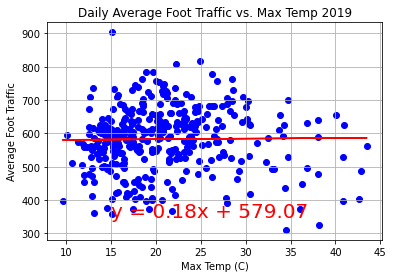

In [35]:
# Scatter plot & regression

x = weather_foottrafic_2019["Maximum temperature (Degree C)"]
y = weather_foottrafic_2019["av foot traffic 2019"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter (x,y, marker="o", facecolors="blue", alpha=1)
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq, (15,350),fontsize=20,color="red")
plt.xlabel("Max Temp (C)")
plt.ylabel("Average Foot Traffic")
plt.title("Daily Average Foot Traffic vs. Max Temp 2019")
print(f"The r-value is: {rvalue}")
plt.grid()
plt.savefig("Fig1.png") 
plt.show()

- There is no relationship / very weak relatiobship between foot traffic vs. weather, r-values are close to 0.
- Melbournians go to Melbourne CBD regardless of weather

## Correlation Analysis - daily average foot traffic 2019 vs. day of the year 2019

In [39]:
# foot traffic data 2019

results_2019_df_2 = results_2019_df.copy()
results_2019_df_2['Date'] = pd.to_datetime(results_2019_df_2["date_time"]).dt.date
results_2019_df_2.head()

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,month+day,Date
0,2887628,2019-11-01T17:00:00.000,2019,November,1,Friday,17,34,Flinders St-Spark La,300.0,November1,2019-11-01
1,2887629,2019-11-01T17:00:00.000,2019,November,1,Friday,17,39,Alfred Place,604.0,November1,2019-11-01
2,2887630,2019-11-01T17:00:00.000,2019,November,1,Friday,17,37,Lygon St (East),216.0,November1,2019-11-01
3,2887631,2019-11-01T17:00:00.000,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627.0,November1,2019-11-01
4,2887632,2019-11-01T17:00:00.000,2019,November,1,Friday,17,36,Queen St (West),774.0,November1,2019-11-01


In [41]:
# foot traffic data 2019 calculation
groupby_date = results_2019_df_2.groupby("Date")

daily_foottraffic_by_date = groupby_date["hourly_counts"].mean()

results_2019_foottraffic_bydate = pd.DataFrame({"Av foot traffic 2019": daily_foottraffic_by_date})
results_2019_foottraffic_bydate = results_2019_foottraffic_bydate.reset_index()
results_2019_foottraffic_bydate.head()

,Date,Av foot traffic 2019
0,2019-01-01,469.195578
1,2019-01-02,522.727891
2,2019-01-03,517.563776
3,2019-01-04,403.606293
4,2019-01-05,454.995833


The r-value is: 0.14195185271907143


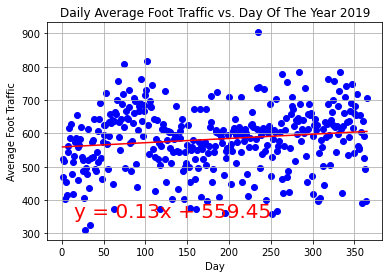

In [42]:
# Scatter plot & regression 

x = np.arange(1,366,1)
y = results_2019_foottraffic_bydate["Av foot traffic 2019"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter (x,y, marker="o", facecolors="blue", alpha=1)
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq, (15,350),fontsize=20,color="red")
plt.xlabel("Day")
plt.ylabel("Average Foot Traffic")
plt.title("Daily Average Foot Traffic vs. Day Of The Year 2019")
print(f"The r-value is: {rvalue}")
plt.grid()
plt.savefig("Fig2.png") 
plt.show()



- There is a very weak relationship between foot traffic vs. day / season of the year, r-value is close to 0.
- Slight increase in foot traffic towards end of the year